# Description

It generates different general plots to compare coefficient values from Pearson, Spearman and Clustermatch, such as their distribution.

In `Settings` below, the data set and other options (such as tissue for GTEx) are specified.

# Modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from clustermatch.coef import cm
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.GTEX
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

# Paths

In [3]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [4]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / f"gtex_{GTEX_TISSUE}"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_whole_blood')

In [5]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [6]:
INPUT_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_FILE)

assert INPUT_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-all.pkl')

# Data

In [7]:
df = pd.read_pickle(INPUT_FILE)

In [8]:
df.shape

(12497500, 3)

In [9]:
df.head()

clustermatch   pearson  spearman
ENSG00000000419.12 ENSG00000002834.17      0.418721  0.681847  0.786595
                   ENSG00000002919.14      0.405090  0.734699  0.816991
                   ENSG00000002933.7       0.007466  0.013825  0.004128
                   ENSG00000003402.19      0.391683  0.727347  0.803653
                   ENSG00000004478.7       0.099013  0.094147  0.231269

## Data stats

In [10]:
df.describe().applymap(str)

,clustermatch,pearson,spearman
count,12497500.0,12497500.0,12497500.0
mean,0.1407816158473381,0.3055270339582277,0.39444206469877185
std,0.14482154890702095,0.24329624620596305,0.2595310853531984
min,-0.0010015912473193929,1.5077467052648785e-08,1.3941559573460438e-08
25%,0.02840489656767938,0.09442322140732318,0.16297401304506182
50%,0.0811105958507932,0.23886133272185917,0.3675595119633454
75%,0.2167198284523933,0.4953853540480224,0.6148954029591087
max,0.9169180125916612,0.9948779504715451,0.9867424080828916


In [11]:
# skewness
df.apply(lambda x: stats.skew(x))

clustermatch    1.283771
pearson         0.622893
spearman        0.245173
dtype: float64

# Histogram plot

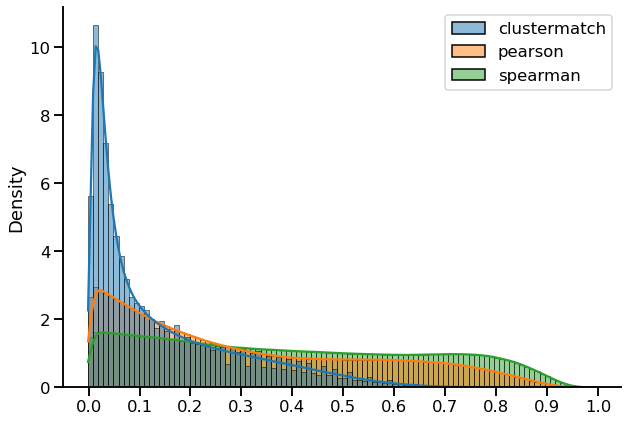

In [12]:
with sns.plotting_context("talk", font_scale=1.0):
    fig, ax = plt.subplots(figsize=(10, 7))

    ax = sns.histplot(
        data=df,
        stat="density",
        bins=100,
        common_bins=True,
        common_norm=False,
        kde=True,
        ax=ax,
    )
    sns.despine(ax=ax)

    ax.set_xticks(np.linspace(0, 1, 10 + 1))

    plt.savefig(
        OUTPUT_FIGURE_DIR / "dist-histograms.svg",
        bbox_inches="tight",
        facecolor="white",
    )

Coefficients' values distribute very differently. Clustermatch is skewed to the left, whereas Pearson and specially Spearman seem more uniform.

# Cumulative histogram plot

I include also a cumulative histogram without specifying `bins`.

In [13]:
_percent = 0.70
_coef_at_percent = df.quantile(_percent)
display(_coef_at_percent)

clustermatch    0.181940
pearson         0.434711
spearman        0.562740
Name: 0.7, dtype: float64

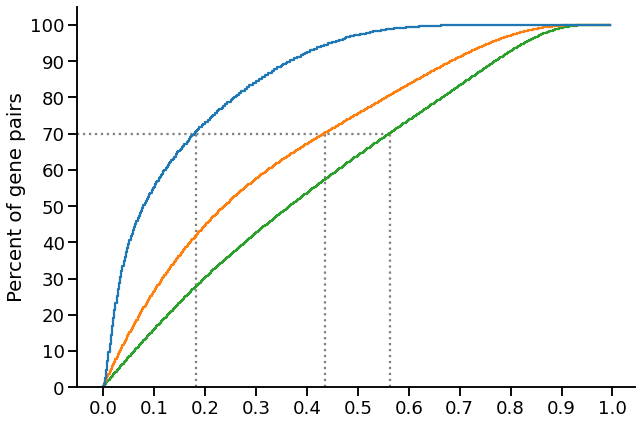

In [14]:
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(10, 7))

    ax = sns.histplot(
        data=df,
        element="step",
        fill=False,
        stat="percent",
        common_norm=False,
        cumulative=True,
        legend=False,
        ax=ax,
    )
    sns.despine(ax=ax)

    ax.set_xticks(np.linspace(0, 1, 10 + 1))
    ax.set_yticks(np.linspace(0, 100, 10 + 1))
    
    ax.set_ylabel("Percent of gene pairs")

    x_lim = ax.get_xlim()
    ax.hlines(
        y=_percent * 100,
        xmin=x_lim[0],
        xmax=_coef_at_percent["spearman"],
        color="gray",
        linestyle="dotted",
    )
    ax.vlines(
        x=_coef_at_percent["clustermatch"],
        ymin=0,
        ymax=_percent * 100,
        color="gray",
        linestyle="dotted",
    )
    ax.vlines(
        x=_coef_at_percent["pearson"],
        ymin=0,
        ymax=_percent * 100,
        color="gray",
        linestyle="dotted",
    )
    ax.vlines(
        x=_coef_at_percent["spearman"],
        ymin=0,
        ymax=_percent * 100,
        color="gray",
        linestyle="dotted",
    )

    ax.set_xlim(x_lim)

    plt.savefig(
        OUTPUT_FIGURE_DIR / "dist-cum_histograms.svg",
        bbox_inches="tight",
        facecolor="white",
    )

# Joint plots comparing each coefficient

In [15]:
import matplotlib as mpl
from matplotlib.colors import LogNorm
from seaborn.distributions import _freedman_diaconis_bins

In [16]:
def jointplot(data, x, y, bins=None):
    """
    Function based on Seaborn's jointplot, but without marginal plots.
    """

    # compute correlations
    x_values = df[x].to_numpy()
    y_values = df[y].to_numpy()
    r = stats.pearsonr(x_values, y_values)[0]
    rs = stats.spearmanr(x_values, y_values)[0]
    c = cm(x_values, y_values)
    xy_corr = {
        "pearson": r,
        "spearman": rs,
        "clustermatch": c,
    }
    
    grid = sns.JointGrid(
        data=data,
        x=x,
        y=y,
    )

    color = "C0"
    color_rgb = mpl.colors.colorConverter.to_rgb(color)
    colors = [sns.utils.set_hls_values(color_rgb, l=l) for l in np.linspace(1, 0, 12)]
    cmap = sns.palettes.blend_palette(colors, as_cmap=True)

    x_bins = min(_freedman_diaconis_bins(grid.x), 50)
    y_bins = min(_freedman_diaconis_bins(grid.y), 50)
    gridsize = int(np.mean([x_bins, y_bins]))

    joint_kws = {
        "bins": bins,
    }

    joint_kws.setdefault("gridsize", gridsize)
    joint_kws.setdefault("cmap", cmap)
    joint_kws.setdefault("rasterized", True)

    grid.plot_joint(
        plt.hexbin,
        **joint_kws,
    )

    # remove marginal axes
    grid.ax_marg_x.set_visible(False)
    grid.ax_marg_y.set_visible(False)
    
    # add text box for the statistics
    ax = grid.ax_joint
    corr_vals = f"$r$ = {r:.2f}\n" f"$r_s$ = {rs:.2f}\n" f"$c$ = {c:.2f}"
    bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.15)
    ax.text(
        0.25,
        0.80,
        corr_vals,
        fontsize=12,
        bbox=bbox,
        transform=ax.transAxes,
        horizontalalignment="right",
    )

    return grid

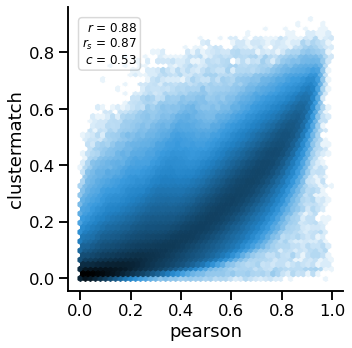

In [17]:
with sns.plotting_context("talk", font_scale=1.0):
    g = jointplot(
        data=df,
        x="pearson",
        y="clustermatch",
        bins="log",
    )

    g.savefig(
        OUTPUT_FIGURE_DIR / "dist-clustermatch_vs_pearson.svg",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

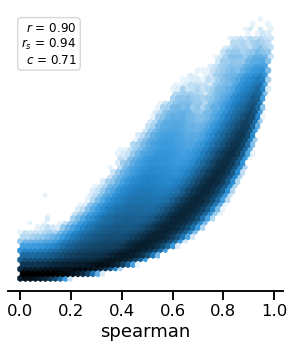

In [18]:
with sns.plotting_context("talk", font_scale=1.0):
    g = jointplot(
        data=df,
        x="spearman",
        y="clustermatch",
        bins="log",
    )

    sns.despine(ax=g.ax_joint, left=True)
    g.ax_joint.set_yticks([])
    g.ax_joint.set_ylabel(None)

    g.savefig(
        OUTPUT_FIGURE_DIR / "dist-clustermatch_vs_spearman.svg",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

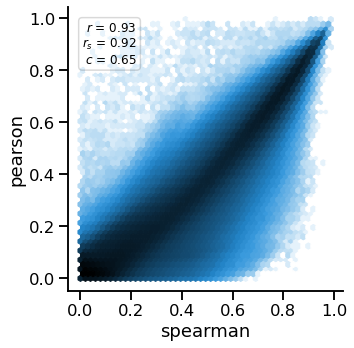

In [19]:
with sns.plotting_context("talk", font_scale=1.0):
    g = jointplot(
        data=df,
        x="spearman",
        y="pearson",
        bins="log",
    )

    g.savefig(
        OUTPUT_FIGURE_DIR / "dist-spearman_vs_pearson.svg",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )